In [1]:
import pandas as pd
import pickle
import numpy as np
# import re
import unicodedata # To convert "weird" Twitter fonts.

from gensim import corpora, models, similarities, matutils

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

from corextopic import corextopic as ct

import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud

# Start with examining the initial twitter search (regular terms, not hashtags)

In [2]:
with open('./data/tweets.pickle','rb') as read_file:
    df = pickle.load(read_file)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Created          10000 non-null  datetime64[ns, UTC]
 1   User_ID          10000 non-null  float64            
 2   User_Name        10000 non-null  object             
 3   Text             10000 non-null  object             
 4   Description      10000 non-null  object             
 5   Location         10000 non-null  object             
 6   Followers_Count  10000 non-null  float64            
 7   Friends_Count    10000 non-null  float64            
 8   Favorite_Count   10000 non-null  float64            
 9   Retweet_Count    10000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(4)
memory usage: 781.4+ KB


In [4]:
print("Earliest Date of search:", min(df.Created))

print("Lastest Date of search:", max(df.Created))

Earliest Date of search: 2022-01-05 22:51:02+00:00
Lastest Date of search: 2022-01-07 23:59:57+00:00


## Tokenize Text

In [37]:
# Use spaCy to tokenize the text.

docs = list(nlp.pipe(df.Text))
df['spacy_doc'] = docs

In [38]:
# Text preprocessing. Removing stop words, puncuation, numbers, and user mentions (i.e., @xx).
# (also remove text used in the search of Twitter (i.e., "new", "years", "resolution")).

docs_clean = [[unicodedata.normalize("NFKC", w.lemma_).lower() for w in doc if \
               (not w.is_stop and \
                not w.is_punct and \
                not w.like_num and \
                "@" not in w.lemma_ and \
                "\n" not in w.lemma_ and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "new" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "year" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "years" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "resolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearsresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "thing" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "bring" and \
                "https" not in w.lemma_ and \
                w.lemma_.lower() != "rt")] for doc in docs]
df['docs_clean'] = docs_clean

In [39]:
# Merge tokens together.
docs_list_clean = [' '.join(doc) for doc in df['docs_clean']]
docs_list_clean[:3]

['holy shit hear read privy literally talk',
 'start consistently blogge coss bunch topic unpac',
 'schedule time problem solve']

## Find Topics (LSA, NMF, LDA) - more like EDA.

In [8]:
# Function to display the top words associated with the topics.

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
def topics_explore(vectorizer, num_topics, doc_lst, redux_model="NMF"):
    
    if redux_model == "NMF" or redux_model == "LSA":
        X = vectorizer.fit_transform(doc_lst)

        if redux_model == "LSA":
            topics = TruncatedSVD(num_topics)
        else:
            topics = NMF(num_topics)

        doc_topic = topics.fit_transform(X)

        return display_topics(topics, vectorizer.get_feature_names(), 10)
    
    elif redux_model == "LDA":
        vectorizer.fit(doc_lst)
        doc_word = vectorizer.transform(doc_lst).transpose()
        corpus = matutils.Sparse2Corpus(doc_word)
        id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
        lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5)
        
        return lda.print_topics()
    
    else:
            return "Select either LSA, NMF, or LDA."

Explored different vectorizers with different parameters and different models to find what seemed like the "best" topics and the words associated with them (for use in the CorEx model below).

In [10]:
tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.70,
                     ngram_range=(2,3),
                     token_pattern="\\b[a-z][a-z]+\\b")

topics_explore(tv, 10, docs_list_clean, "LSA")


Topic  0
maine house, republicans present, jan washington, washington republicans present, republicans present maine, jan washington republicans, present maine, polarization jan washington, polarization jan, washington republicans

Topic  1
goal home, home place, goal home place, home place help, place help, giveaway enter, enter follow, allow wendy shay, wendy shay, allow wendy

Topic  2
isoroom giveaway isofam, giveaway isofam, giveaway isofam grateful, isofam grateful, isoroom giveaway, let start, lose weight, write way, pair denim, buy pair

Topic  3
moment great, great opportunity, great opportunity come, moment great opportunity, great difficulty moment, great difficulty, difficulty moment great, difficulty moment, opportunity come, moment great difficulty

Topic  4
hope dream, reflect idea share, week reflect idea, hope dream week, mean goal hope, idea share, goal hope dream, goal hope, reflect idea, week reflect

Topic  5
boyz world tour, pick definitely want, definitely want,

In [11]:
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.70,
                     ngram_range=(2,3),
                     token_pattern="\\b[a-z][a-z]+\\b")

topics_explore(cv, 10, docs_list_clean, "LDA")

[(0,
  '0.626*"read book" + 0.001*"set goal" + 0.001*"lose weight" + 0.001*"dev challenge" + 0.001*"article dev" + 0.001*"article dev challenge" + 0.001*"thank write helpful" + 0.001*"helpful article dev" + 0.001*"write helpful" + 0.001*"helpful article"'),
 (1,
  '0.464*"leave week" + 0.149*"check article" + 0.001*"lose weight" + 0.001*"dev challenge" + 0.001*"thank write helpful" + 0.001*"thank write" + 0.001*"article dev challenge" + 0.001*"write helpful article" + 0.001*"write helpful" + 0.001*"helpful article"'),
 (2,
  '0.051*"enter follow" + 0.043*"retweet like" + 0.043*"giveaway enter" + 0.043*"giveaway enter follow" + 0.043*"retweet like comment" + 0.043*"royale giveaway" + 0.043*"royale giveaway enter" + 0.043*"like comment" + 0.043*"like comment optional" + 0.043*"comment optional"'),
 (3,
  '0.041*"tweet covid travel" + 0.041*"covid travel country" + 0.041*"travel country" + 0.041*"tweet covid" + 0.041*"covid travel" + 0.019*"vote vote" + 0.019*"let message" + 0.019*"defend

## CorEx Model

In [12]:
df["Text_clean"] = df["docs_clean"].map(lambda x: " ".join(x))

In [13]:
# CorEx requires counts to work best.
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.70,
                     ngram_range=(2,3),
                     token_pattern="\\b[a-z][a-z]+\\b")

doc_word = cv.fit_transform(df.Text_clean)
words = list(np.asarray(cv.get_feature_names()))

words[:10]

['abandon disappear',
 'abandon disappear refer',
 'ah htt',
 'airlines flight',
 'airlines flight kill',
 'allow wendy',
 'allow wendy shay',
 'american archaeolo',
 'americans drive',
 'americans drive onmyway']

In [14]:
# Ideally the anchor list is shorter than the number of topics wanted so 
# other topics can be identified.
anchor_lst = [["republicans present", "jan washington", 
               "jan washington republicans", "polarization jan", 
               "polarization jan washington"],
              ["isoroom giveaway", "giveaway isofam", "isofam grateful",
              "need retweet", "giveaway enter need"], 
              ["financial freedom" ,"financial financial",
              "financial financial freedom"],
              ["travel country", "covid travel",
              "covid travel country", "covid travel country"],
              ["hope dream", "week reflect idea",
              "idea share", "dream week reflect"],
             ["opportunity come", "great opportunity come",
             "great difficulty"]]

### BEGIN SOLUTION
topic_model = ct.Corex(n_hidden= 10, ### NUMBER OF TOPICS HERE
                       words= words,  ### VOCABULARY HERE
                       seed=1
                       )

topic_model.fit(  doc_word,          ### DOCUMENT TERM MATRIX HERE
                words=  words,      ### VOCABULARY HERE
                docs=  df["Text"],        ### DOCUMENT SERIES HERE
                anchors=anchor_lst,          ### ANCHOR LISTS HERE
                anchor_strength= 5  ### ANCHOR STRENGTH HERE
                );

topics = topic_model.get_topics()

labels = ["Politics", "Giveaways", "Finances", "Travel", "Hopes_Dreams",
          "New_Beginnings", "K_Pop_Band", "Unidentified_1", 
          "Unidentified_2", "Unidentified_3"]

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{labels[n]}: {", ".join(topic_words)}\n')

Politics: republicans present, jan washington, jan washington republicans, polarization jan washington, polarization jan, present maine, republicans present maine, washington republicans, washington republicans present, maine house vot

Giveaways: isofam grateful, giveaway isofam, isoroom giveaway, need retweet, giveaway enter need, giveaway isofam grateful, isoroom giveaway isofam, giveaway enter, retweet like comment, pass royale giveaway

Finances: financial freedom, financial financial freedom, financial financial, dev challenge, join million, let end, million americans drive, drive onmyway let, drive onmyway, need join

Travel: travel country, covid travel, covid travel country, tweet covid travel, tweet covid, target race join, target race, senate majority target, senate majority, race join today

Hopes_Dreams: hope dream, week reflect idea, idea share, dream week reflect, mean goal hope, mean goal, hope dream week, reflect idea share, goal hope dream, goal hope

New_Beginnings: 

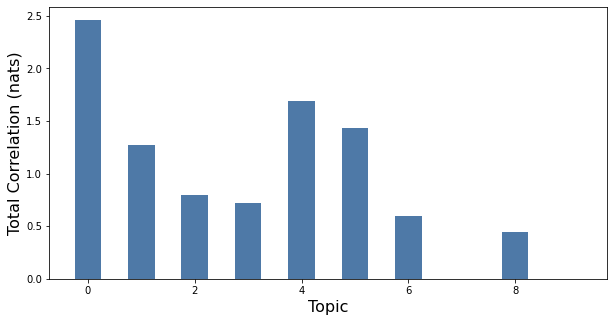

In [15]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [16]:
# Save the dataframe with the probability of being in the certain topics 
# for future sentiment analysis.

# To get probabilities of being in the topic groups:
# predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[labels[i] for i in range(10)])
# To get T/F of being in the topic groups:
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=[labels[i] for i in range(10)])

predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Politics        10000 non-null  bool 
 1   Giveaways       10000 non-null  bool 
 2   Finances        10000 non-null  bool 
 3   Travel          10000 non-null  bool 
 4   Hopes_Dreams    10000 non-null  bool 
 5   New_Beginnings  10000 non-null  bool 
 6   K_Pop_Band      10000 non-null  bool 
 7   Unidentified_1  10000 non-null  bool 
 8   Unidentified_2  10000 non-null  bool 
 9   Unidentified_3  10000 non-null  bool 
dtypes: bool(10)
memory usage: 97.8 KB


In [17]:
df = pd.concat([df, predictions], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Created          10000 non-null  datetime64[ns, UTC]
 1   User_ID          10000 non-null  float64            
 2   User_Name        10000 non-null  object             
 3   Text             10000 non-null  object             
 4   Description      10000 non-null  object             
 5   Location         10000 non-null  object             
 6   Followers_Count  10000 non-null  float64            
 7   Friends_Count    10000 non-null  float64            
 8   Favorite_Count   10000 non-null  float64            
 9   Retweet_Count    10000 non-null  float64            
 10  spacy_doc        10000 non-null  object             
 11  docs_clean       10000 non-null  object             
 12  Text_clean       10000 non-null  object             
 13  Politics         

In [18]:
with open('./data/df_no_hashtags.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

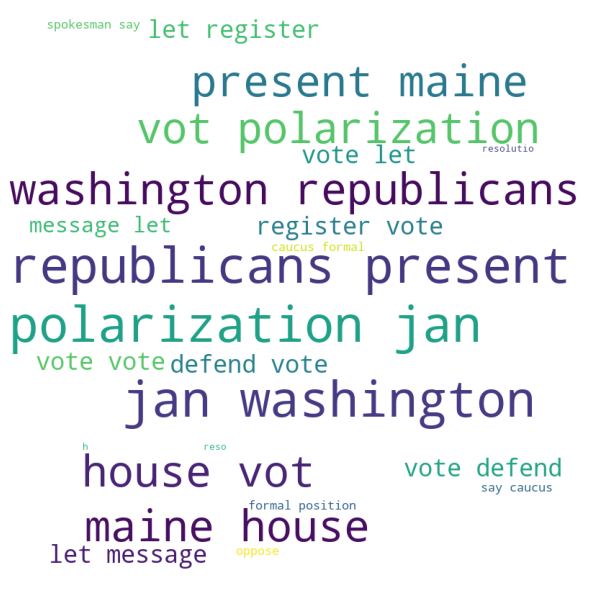

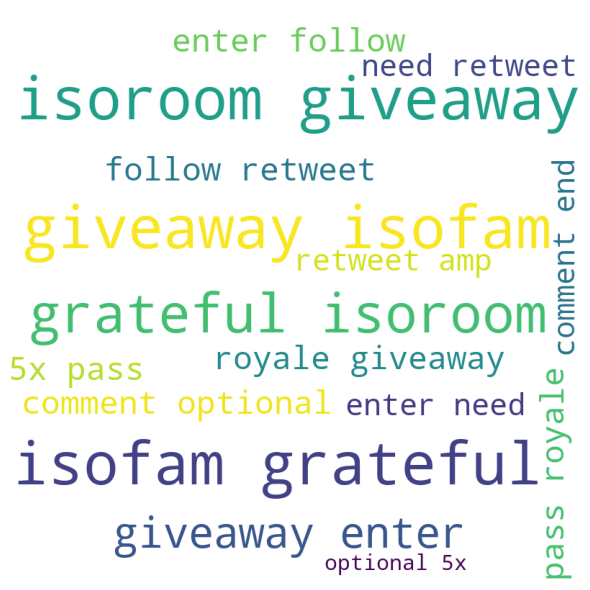

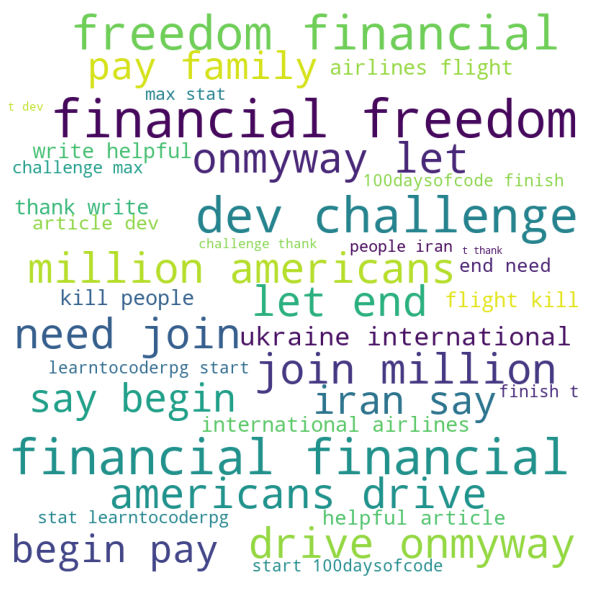

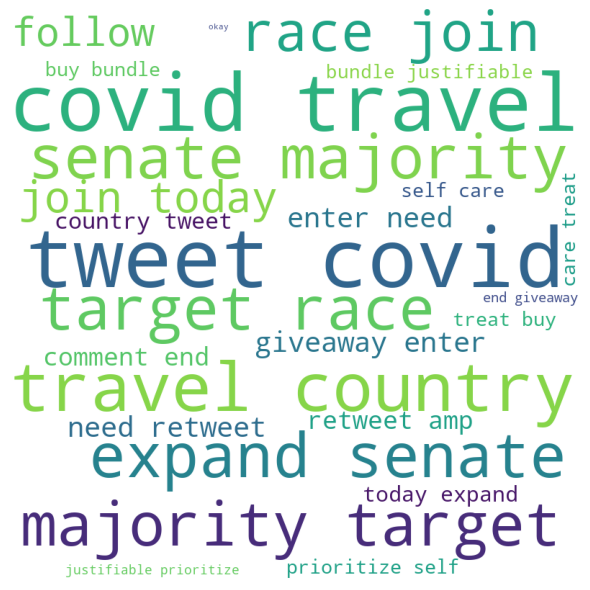

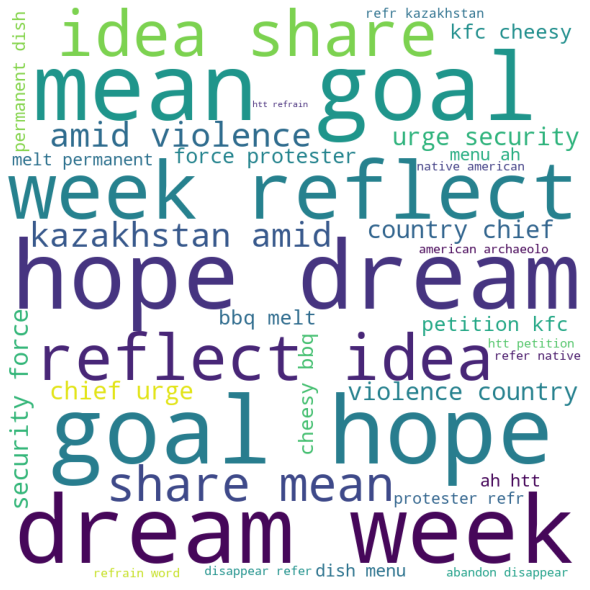

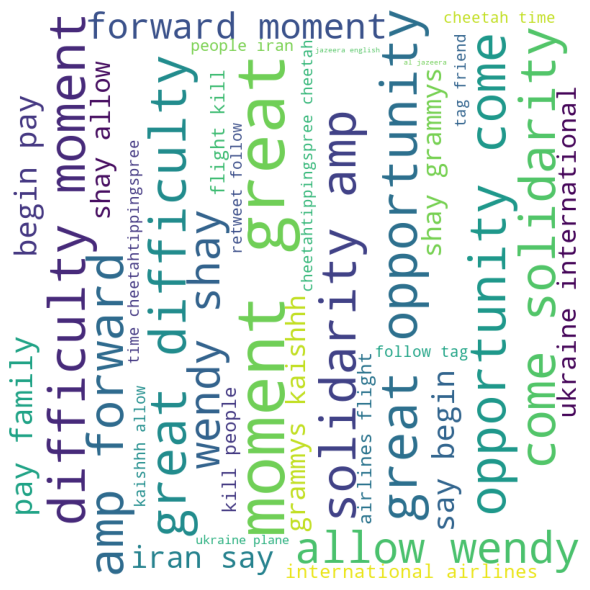

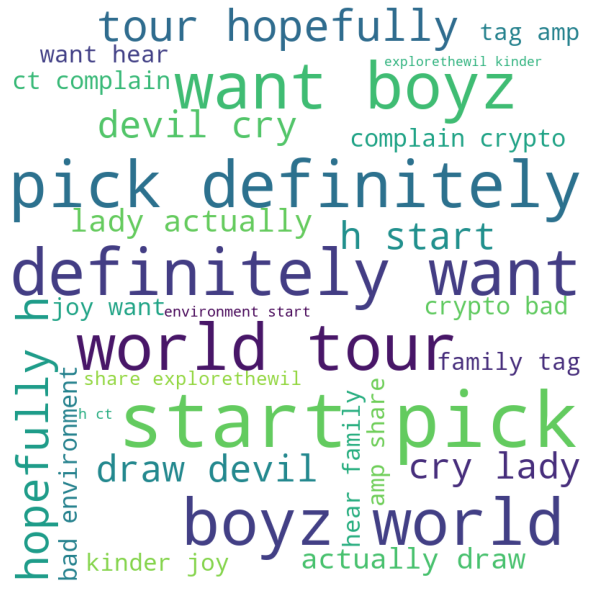

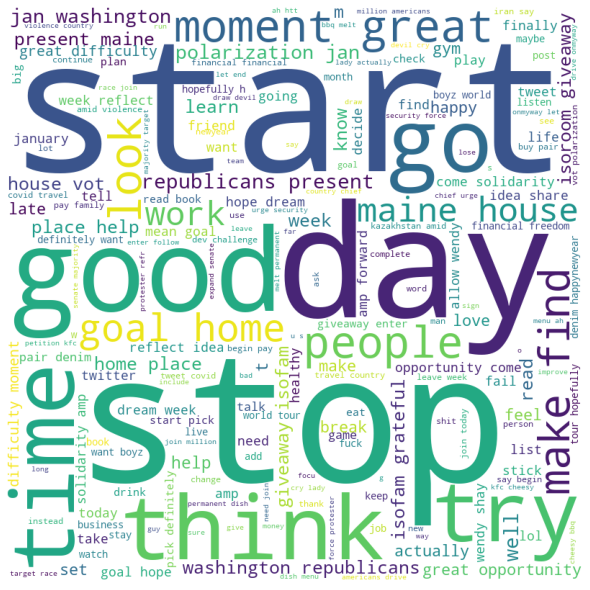

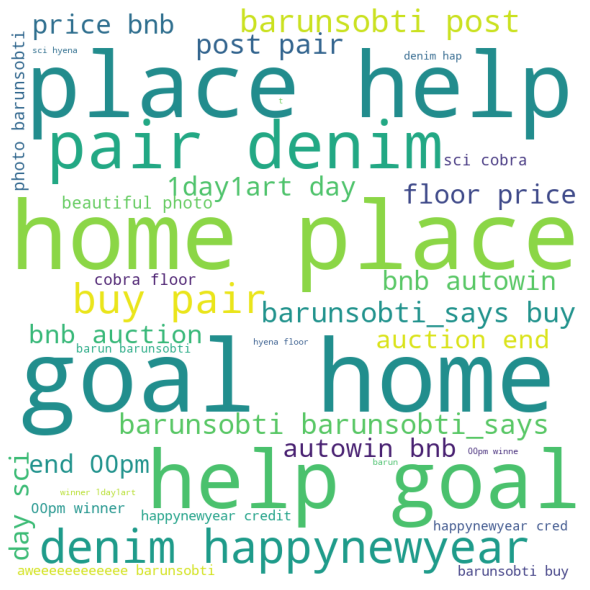

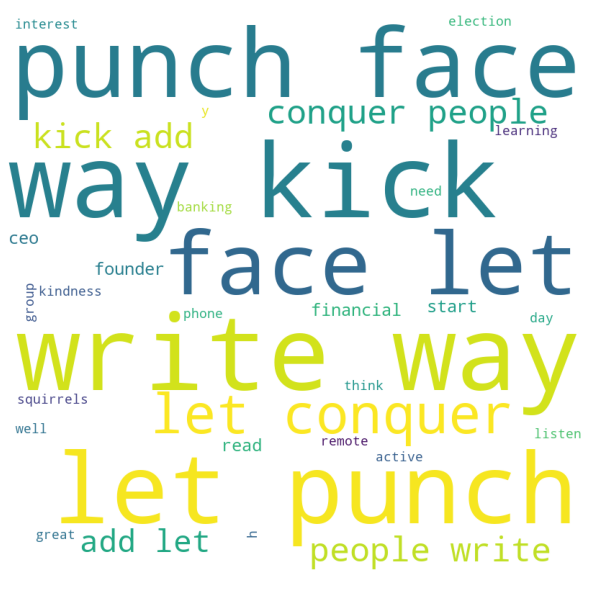

In [19]:
# Create a word cloud to illustrate the top words/phrases.
# Create and save a word cloud for each topic found above.

labels = ["Politics", "Giveaways", "Finances", "Travel", "Hopes_Dreams",
          "New_Beginnings", "K_Pop_Band", "Unidentified_1", 
          "Unidentified_2", "Unidentified_3"]

for x in labels:
    
    df_text = df.query(f"{x} == True")

    words = " ".join(df_text.Text_clean)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig(f"./Figures/word_cloud_{x}.png", dpi=200);

# Now examine the hashtags download.

In [5]:
with open('./data/tweets_n3.pickle','rb') as read_file:
    df2 = pickle.load(read_file)

In [6]:
print("Earliest Date of search:", min(df2.Created))

print("Lastest Date of search:", max(df2.Created))

Earliest Date of search: 2022-01-11 23:28:03+00:00
Lastest Date of search: 2022-01-19 17:13:08+00:00


In [21]:
docs = list(nlp.pipe(df2.Text))
df2['spacy_doc'] = docs

In [22]:
# Text preprocessing. Removing stop words, puncuation, numbers, and user mentions (i.e., @xx).
# (also remove text used in the search of Twitter (i.e., "new", "years", "resolution")).

docs_clean2 = [[unicodedata.normalize("NFKC", w.lemma_).lower() for w in doc if \
               (not w.is_stop and \
                not w.is_punct and \
                not w.like_num and \
                "@" not in w.lemma_ and \
                "\n" not in w.lemma_ and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "new" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "year" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "years" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "resolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearsresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "thing" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "bring" and \
                "https" not in w.lemma_ and \
                w.lemma_.lower() != "rt")] for doc in docs]
df2['docs_clean'] = docs_clean2

In [23]:
# Merge tokens together.
docs_list_clean2 = [' '.join(doc) for doc in df2['docs_clean']]
docs_list_clean2[:3]

['want change life well use learn set goal',
 '100daysofcodechallenge day9 👨 \u200d 💻 complete camper cafe menu task html css 📖 upskilli',
 'save robot vacuum deenkee wi fi app alexa robot vacuum cleaner,1600 pa suction mins runtime pet hai']

## EDA topic modeling search

In [24]:
tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.005, 
                     max_df = 0.50,
                     ngram_range=(1,3),
                     token_pattern="\\b[a-z][a-z]+\\b")

topics_explore(tv, 10, docs_list_clean2, "LSA")


Topic  0
alcohol, stop, drinking, drinking alcohol, stop drinking, stop drinking alcohol, drink, drink alcohol, intoxication, consume

Topic  1
forget, follow, georgie wil, follow forget georgie, follow forget, forget georgie, forget georgie wil, georgie, wil, healthy

Topic  2
say, garibdas, garibdas ji, ji, ji say, garibdas ji say, sant garibdas, sant garibdas ji, drinking alcohol sin, alcohol sin

Topic  3
start, way, check, grab, moon, bang, bang grab, start bang, nyr way, nyr way moon

Topic  4
life, consume, drink, consume alcohol, drink alcohol, day, know, rampal ji, rampal, goal

Topic  5
consume, consume alcohol, rampal, rampal ji, sant rampal, sant rampal ji, ji, ji maharaj, maharaj, rampal ji maharaj

Topic  6
life, away, far, great, far away, life great, great death far, life great death, great death, away video occasion

Topic  7
time, liquor, consume liquor, kabir, consume liquor time, liquor time, kabir saheb, saheb, constitution world, explain constitution world

Topic

In [25]:
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.60,
                     ngram_range=(1,2),
                     token_pattern="\\b[a-z][a-z]+\\b")

topics_explore(cv, 10, docs_list_clean2, "LDA")

[(0,
  '0.037*"day" + 0.034*"human" + 0.032*"life" + 0.031*"learn" + 0.027*"alcohol" + 0.023*"hope" + 0.021*"happy" + 0.020*"health" + 0.019*"human life" + 0.016*"social"'),
 (1,
  '0.167*"follow" + 0.096*"alcohol" + 0.067*"stop" + 0.061*"drinking" + 0.057*"drinking alcohol" + 0.051*"stop drinking" + 0.024*"drink" + 0.018*"drink alcohol" + 0.012*"wil" + 0.011*"sin"'),
 (2,
  '0.030*"person" + 0.025*"bang" + 0.025*"ji" + 0.024*"say" + 0.024*"alcohol" + 0.023*"garibdas" + 0.023*"garibdas ji" + 0.022*"ji say" + 0.021*"sant" + 0.020*"sant garibdas"'),
 (3,
  '0.091*"life" + 0.044*"great" + 0.043*"love" + 0.032*"video" + 0.027*"step" + 0.027*"change" + 0.027*"away" + 0.025*"far" + 0.023*"know" + 0.023*"death"'),
 (4,
  '0.035*"stop" + 0.028*"alcohol" + 0.028*"body" + 0.021*"important" + 0.019*"liver" + 0.019*"organ" + 0.019*"destroy" + 0.019*"important organ" + 0.019*"organ body" + 0.019*"consume"'),
 (5,
  '0.024*"today" + 0.023*"share" + 0.023*"join" + 0.023*"meat" + 0.022*"hell" + 0.022*

## CorEx Modeling 

In [26]:
df2["Text_clean"] = df2["docs_clean"].map(lambda x: " ".join(x))

In [27]:
# CorEx requires counts to work best.
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.005, 
                     max_df = 0.50,
                     ngram_range=(1,3),
                     token_pattern="\\b[a-z][a-z]+\\b")

doc_word = cv.fit_transform(df2.Text_clean)
words = list(np.asarray(cv.get_feature_names()))

words[:10]

['abandon',
 'accord',
 'accord constitution',
 'accord constitution god',
 'account',
 'achieve',
 'ad',
 'ad gt',
 'ad gt gt',
 'addiction']

In [28]:
# Ideally the anchor list is shorter than the number of topics wanted so 
# other topics can be identified.
anchor_lst = [["consume alcohol", "drinking alcohol", "stop drinking",
               "alcohol", "drink alcohol", "alcohol sin", "intoxication",
              "stop consume", "consume liquor", "liquor"],
             ["meat", "govegan", "animal"],
             ["nyr"]]

### BEGIN SOLUTION
topic_model = ct.Corex(n_hidden= 5, ### NUMBER OF TOPICS HERE
                       words= words,  ### VOCABULARY HERE
                       seed=1
                       )

topic_model.fit(  doc_word,          ### DOCUMENT TERM MATRIX HERE
                words=  words,      ### VOCABULARY HERE
                docs=  df2["Text"],        ### DOCUMENT SERIES HERE
                anchors=anchor_lst,          ### ANCHOR LISTS HERE
                anchor_strength= 5  ### ANCHOR STRENGTH HERE
                );

topics = topic_model.get_topics()

labels = ["Alcohol", "Vegan", "NYR_crypto",
          "Unidentified_hash_1", "Unidentified_hash_1"]

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{labels[n]}: {", ".join(topic_words)}\n')

Alcohol: alcohol, drinking alcohol, stop drinking, consume alcohol, drink alcohol, stop consume, alcohol sin, stop, drinking, consume liquor

Vegan: meat, animal, govegan, govegan turkey, trap hell govegan, trap hell, share hide animal, share hide, ndwyl meat, ndwyl

NYR_crypto: nyr, way moon, nyr way, nyr way moon, grab nyr way, grab nyr, start bang grab, start bang, bang grab nyr, bang grab

Unidentified_hash_1: garibdas ji say, ji say, garibdas, garibdas ji, sant garibdas ji, sant garibdas, say, madira, paani, sattar

Unidentified_hash_1: follow forget, forget georgie, forget georgie wil, georgie wil, georgie, follow forget georgie, wil, forget, follow, liquor time



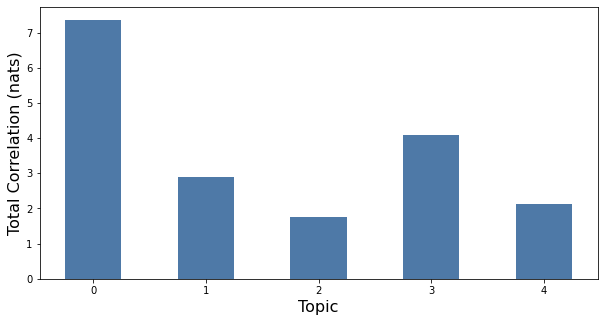

In [29]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [30]:
# Save the dataframe with the probability of being in the certain topics 
# for future sentiment analysis.

# To get probabilities of being in the topic groups:
# predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[labels[i] for i in range(10)])
# To get T/F of being in the topic groups:
predictions2 = pd.DataFrame(topic_model.predict(doc_word), columns=[labels[i] for i in range(5)])

predictions2.head()

,Alcohol,Vegan,NYR_crypto,Unidentified_hash_1,Unidentified_hash_1
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,True,False,False,True,False
4,True,False,False,False,False


In [31]:
df2 = pd.concat([df2, predictions2], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6660 entries, 0 to 6659
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Created              6660 non-null   datetime64[ns, UTC]
 1   User_ID              6660 non-null   float64            
 2   User_Name            6660 non-null   object             
 3   Text                 6660 non-null   object             
 4   Description          6660 non-null   object             
 5   Location             6660 non-null   object             
 6   Followers_Count      6660 non-null   float64            
 7   Friends_Count        6660 non-null   float64            
 8   Favorite_Count       6660 non-null   float64            
 9   Retweet_Count        6660 non-null   float64            
 10  spacy_doc            6660 non-null   object             
 11  docs_clean           6660 non-null   object             
 12  Text_clean          

In [32]:
with open('./data/df_with_hashtags.pickle', 'wb') as to_write:
    pickle.dump(df2, to_write)

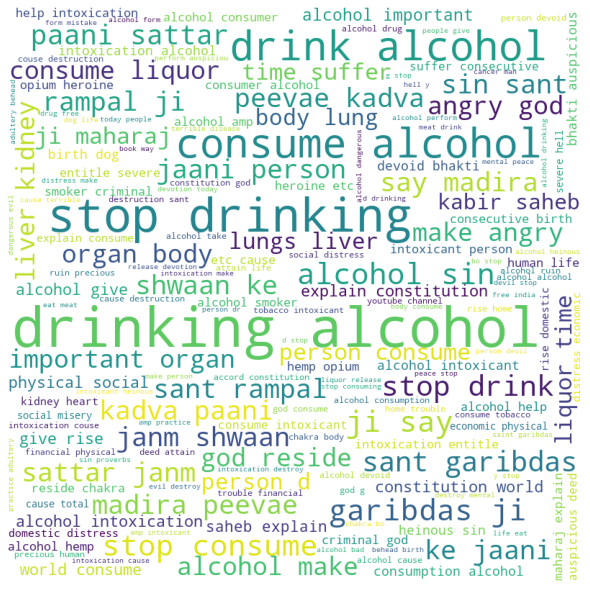

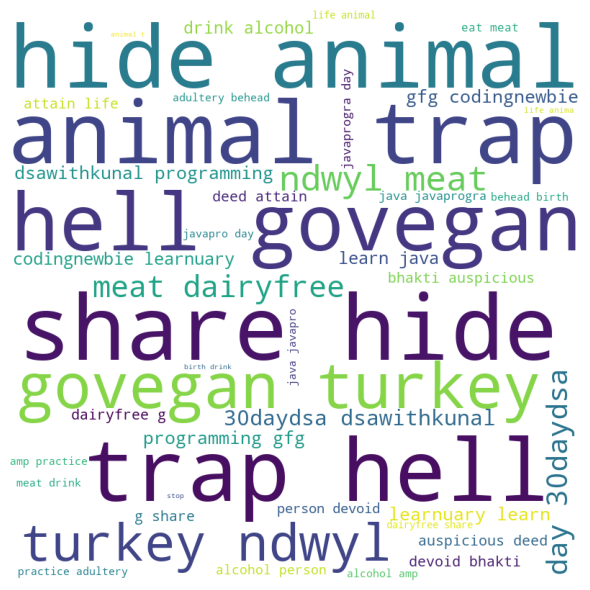

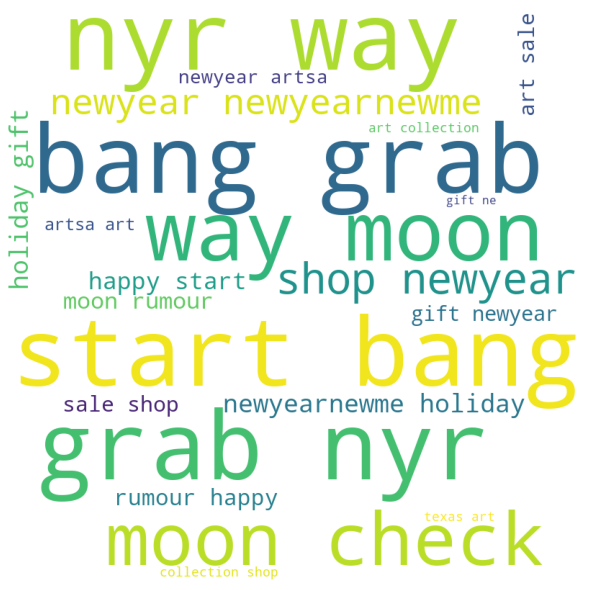

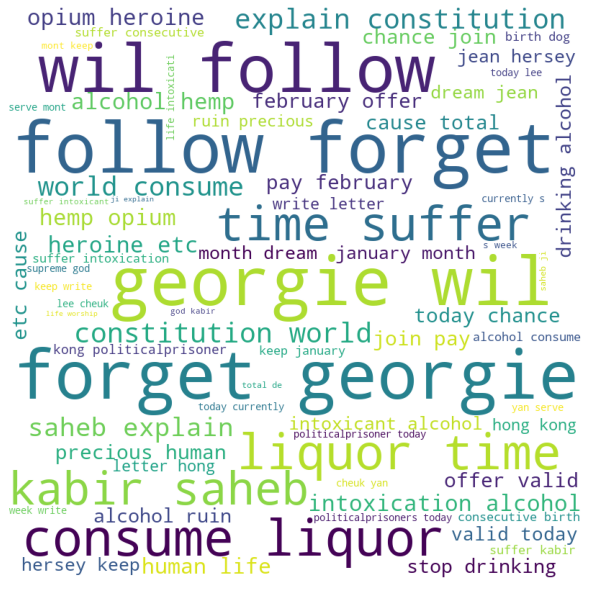

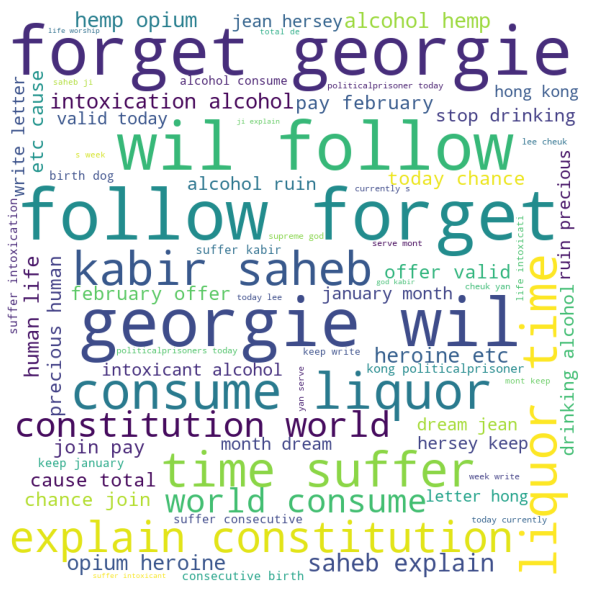

In [33]:
# Create a word cloud to illustrate the top words/phrases.
# Create and save a word cloud for each topic found above.

labels = ["Alcohol", "Vegan", "NYR_crypto",
          "Unidentified_hash_1", "Unidentified_hash_1"]

for x in labels:
    
    df_text = df2.query(f"{x} == True")

    words = " ".join(df_text.Text_clean)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig(f"./Figures/word_cloud_{x}.png", dpi=200);

## Try dropping tweets with media.

In [4]:
with open('./data/tweets.pickle','rb') as read_file:
    df_media = pickle.load(read_file)


In [6]:
# Use spaCy to tokenize the text.

docs = list(nlp.pipe(df_media.Text))
df_media['spacy_doc'] = docs

In [7]:
# Text preprocessing. Removing stop words, puncuation, numbers, and user mentions (i.e., @xx).
# (also remove text used in the search of Twitter (i.e., "new", "years", "resolution")).

docs_clean = [[unicodedata.normalize("NFKC", w.lemma_).lower() for w in doc if \
               (not w.is_stop and \
                not w.is_punct and \
                not w.like_num and \
                "@" not in w.lemma_ and \
                "\n" not in w.lemma_ and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "new" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "year" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "years" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "resolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "newyearsresolution" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "thing" and \
                 unicodedata.normalize("NFKC", w.lemma_).lower() != "bring" and \
#                 "https" not in w.lemma_ and \
                w.lemma_.lower() != "rt")] for doc in docs]
df_media['docs_clean'] = docs_clean

In [8]:
# Function to identify if there is a media attachment to tweet.
def web_address_find(lst: list, string: str):
    """
    Take in a list of words and search for the string within that list.
    Returns yes/no depending if string is found in list.
    """
    for word in lst:
        if word.find(string) > -1:
            return "Yes"
    return "No"

In [9]:
df_media["media"] = df_media.docs_clean.map(lambda x: web_address_find(x, "htt"))

# Try dropping those with media attachments in their tweets.
df_media = df_media.query("media == 'No'")

df_media.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9204 entries, 0 to 6659
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Created          9204 non-null   datetime64[ns, UTC]
 1   User_ID          9204 non-null   float64            
 2   User_Name        9204 non-null   object             
 3   Text             9204 non-null   object             
 4   Description      9204 non-null   object             
 5   Location         9204 non-null   object             
 6   Followers_Count  9204 non-null   float64            
 7   Friends_Count    9204 non-null   float64            
 8   Favorite_Count   9204 non-null   float64            
 9   Retweet_Count    9204 non-null   float64            
 10  spacy_doc        9204 non-null   object             
 11  docs_clean       9204 non-null   object             
 12  media            9204 non-null   object             
dtypes: datetime64[ns, 

In [10]:
# Merge tokens together.
docs_list_clean = [' '.join(doc) for doc in df_media['docs_clean']]
docs_list_clean[:3]

['holy shit hear read privy literally talk',
 'schedule time problem solve',
 'fly private']

In [24]:
tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.009, 
                     max_df = 0.6,
                     ngram_range=(1,2),
                     token_pattern="\\b[a-z][a-z]+\\b")

topics_explore(tv, 10, docs_list_clean, "LDA")

[(0,
  '0.097*"life" + 0.092*"body" + 0.077*"time" + 0.054*"sin" + 0.053*"alcohol" + 0.047*"healthy" + 0.044*"set" + 0.041*"enter" + 0.039*"week" + 0.039*"big"'),
 (1,
  '0.090*"wil" + 0.059*"drinking" + 0.055*"drinking alcohol" + 0.052*"god" + 0.044*"stop drinking" + 0.040*"good" + 0.033*"family" + 0.030*"help" + 0.030*"right" + 0.030*"person"'),
 (2,
  '0.119*"follow" + 0.112*"forget" + 0.111*"georgie" + 0.111*"georgie wil" + 0.111*"follow forget" + 0.111*"forget georgie" + 0.074*"like" + 0.074*"day" + 0.050*"consume alcohol" + 0.032*"think"'),
 (3,
  '0.104*"love" + 0.102*"free" + 0.090*"giveaway" + 0.083*"bad" + 0.067*"suffer" + 0.065*"jan" + 0.063*"make" + 0.060*"eat" + 0.050*"check" + 0.043*"grateful"'),
 (4,
  '0.092*"work" + 0.058*"buy" + 0.057*"book" + 0.053*"country" + 0.048*"social" + 0.042*"home" + 0.037*"explain" + 0.037*"rise" + 0.036*"physical" + 0.036*"tweet"'),
 (5,
  '0.178*"happy" + 0.149*"learn" + 0.141*"want" + 0.141*"write" + 0.104*"world" + 0.062*"important" + 0.